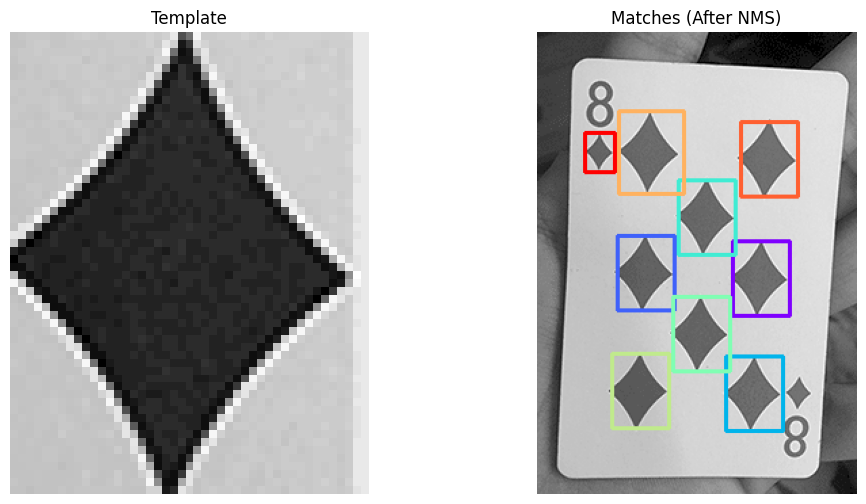

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to apply Non-Maximum Suppression (NMS) to filter overlapping bounding boxes
def non_max_suppression(boxes, scores, overlap_thresh=0.5):
    """Applies Non-Maximum Suppression (NMS) to retain only the most confident detections."""
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    # Extract coordinates of bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    indices = np.argsort(scores)[::-1]  # Sort boxes by confidence scores in descending order

    keep = []  # List to store final selected bounding boxes
    while len(indices) > 0:
        i = indices[0]  # Select the box with the highest confidence score
        keep.append(i)

        # Compute intersection-over-union (IoU) for overlap suppression
        xx1 = np.maximum(x1[i], x1[indices[1:]])
        yy1 = np.maximum(y1[i], y1[indices[1:]])
        xx2 = np.minimum(x2[i], x2[indices[1:]])
        yy2 = np.minimum(y2[i], y2[indices[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[indices[1:]]

        indices = indices[np.where(overlap <= overlap_thresh)[0] + 1]

    return boxes[keep]

# Load the template and the image
template = cv2.imread('/content/template.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('/content/templateMatchingImage.png', cv2.IMREAD_GRAYSCALE)

# Define scale range for multi-scale template matching
scales = np.linspace(0.5, 1.5, 10)  # Scales from 50% to 150% of the original size
threshold = 0.98  # Matching threshold

all_boxes = []  # Store all detected bounding boxes
all_scores = []  # Store corresponding confidence scores

# Perform multi-scale template matching
for scale in scales:
    scaled_template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    result = cv2.matchTemplate(image, scaled_template, cv2.TM_CCORR_NORMED)  # Perform template matching
    loc = np.where(result >= threshold)  # Identify matches above the threshold

    # Store detected bounding boxes and scores
    for pt in zip(*loc[::-1]):
        all_boxes.append((pt[0], pt[1], scaled_template.shape[1], scaled_template.shape[0]))
        all_scores.append(result[pt[1], pt[0]])

# Apply NMS to remove overlapping detections
filtered_boxes = non_max_suppression(all_boxes, all_scores)

# Draw bounding boxes on the matched image
matched_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
colors = iter(cm.rainbow(np.linspace(0, 1, len(filtered_boxes))))

for box in filtered_boxes:
    x, y, w, h = box
    color = next(colors)[:-1]  # Exclude alpha channel
    color = tuple([int(255 * c) for c in color])  # Convert to 0-255 range
    cv2.rectangle(matched_image, (x, y), (x + w, y + h), color, 2)  # Draw rectangle

# Display the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(template, cmap='gray')
axes[0].set_title('Template')
axes[0].axis('off')

axes[1].imshow(matched_image, cmap='gray')
axes[1].set_title('Matches (After NMS)')
axes[1].axis('off')

plt.show()

